# 环境变量

In [1]:
novel_path='./零之使魔.txt'
output_dir='./output_zero/'

chapter_titles_path=output_dir+'chapter_titles.txt'
faiss_path=output_dir+'faiss_index'
novel_chunk_dir=output_dir+'novel_chunks/'
distilled_log_dir=output_dir+'distilled_log/'
distilled_interveiw_dir=output_dir+'distilled_interveiw/'
rename_map_path=output_dir+'rename_map.json'

bg_hint_len=400
summary_len=100
retrospect_len=100
chunk_len=750


import os,json
os.path.exists(output_dir) or os.mkdir(output_dir)
os.path.exists(novel_chunk_dir) or os.mkdir(novel_chunk_dir)
os.path.exists(distilled_log_dir) or os.mkdir(distilled_log_dir)
os.path.exists(distilled_interveiw_dir) or os.mkdir(distilled_interveiw_dir)

rename_map=json.load(open(rename_map_path,'r',encoding='utf-8')) if os.path.exists(rename_map_path) else {}

# 加载LLM

In [2]:
import importlib,my_llm;importlib.reload(my_llm)
# from my_llm import llm_chatglm as llm
from my_llm import llm_chatgpt as llm
llm('你好')

c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\llms\openai.py:165: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\llms\openai.py:676: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


你好你好！有什么我可以帮助你的吗？


'你好！有什么我可以帮助你的吗？'

# 加载FAISS知识索引

In [3]:
import importlib,my_faiss;importlib.reload(my_faiss)
from my_faiss import FAISS,embeddings,get_bg_hint
get_bg_hint.vector_store=FAISS.load_local(faiss_path, embeddings)

No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.
No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.
No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.
No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.


# 加载小说，分块

replace 8 names
saved to  ./output_zero/chapter_titles.txt
第零卷 塔芭莎的冒险 塔芭莎与翼龙人 19052
第零卷 塔芭莎的冒险 塔芭莎和吸血鬼 22293
第零卷 塔芭莎的冒险 塔芭莎与暗杀者 21351
第零卷 塔芭莎的冒险 塔芭莎与魔法人偶 24413
第零卷 塔芭莎的冒险 后记 1247
第零卷 塔芭莎的冒险 塔芭莎与赌徒 18378
第零卷 塔芭莎的冒险 塔芭莎与米诺塔洛斯 18147
第零卷 塔芭莎的冒险 希儿菲朵的一天 5483
第零卷 塔芭莎的冒险 塔芭莎与极乐鸟 15336
第零卷 塔芭莎的冒险 塔芭莎与军港 21795
第零卷 塔芭莎的冒险 后记 1088
第零卷 塔芭莎的冒险 第九话 塔芭莎与希儿菲朵 10639
第零卷 塔芭莎的冒险 第十话 塔芭莎与老战士 16469
第零卷 塔芭莎的冒险 第十一话 塔芭莎与初恋 9299
第二章 5245
第零卷 塔芭莎的冒险 第十二话 塔芭莎诞生 1298
第一章 7631
第二章 4914
第三章 9420
第零卷 塔芭莎的冒险 后记 870


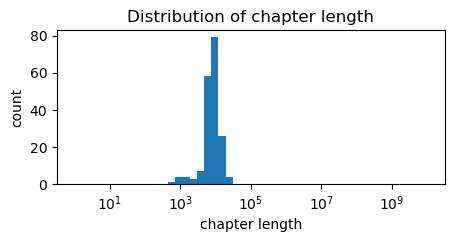

Number of chapters:  186


In [4]:
with open(novel_path) as f:
    all_text = f.read()

for from_name,to_name in rename_map.items():
    all_text=all_text.replace(from_name,to_name)
print('replace {0} names'.format(len(rename_map)))

import re
all_text=re.sub(r'\r', '', all_text)
all_text=re.sub(r'\n+', '\n', all_text)
all_text=re.sub(r'^\s+', '', all_text,flags=re.MULTILINE)

# re_chapter_title=re.compile(r'^(?=第.{1,9}(?=章|卷))', flags=re.MULTILINE)
# re_chapter_title=re.compile(r"^(.{1,8}章|.{1,8}篇|.{1,8}集|.{1,8}卷|后记|序)\s", flags=re.MULTILINE)
re_chapter_title=re.compile(r'^(第.{1,9}(?=章|卷|篇|集|话)|序章|序|后记)', flags=re.MULTILINE)
chapters=re.split(re_chapter_title,all_text)[1:]
chapters=[chapters[i]+chapters[i+1] for i in range(0,len(chapters),2)]
# append the chapter with <100 characters to the next chapter
for i in range(len(chapters)-1):
    if len(chapters[i])<100:
        chapters[i+1]=chapters[i]+chapters[i+1]
        chapters[i]=''
chapters=[chapter for chapter in chapters if chapter!='']

chapter_titles=[chapter.split('\n')[0] for chapter in chapters]

with open(chapter_titles_path,'w') as f:
    # pring chapter_titles, length of chapter
    for chapter_title, chapter in zip(chapter_titles, chapters):
        f.write(chapter_title+'\t'+str(len(chapter))+'\n')
print('saved to ',chapter_titles_path)


for i in range(min(20,len(chapters))):
    print(chapter_titles[i],len(chapters[i]))

import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(5, 2))
plt.hist([len(chapter) for chapter in chapters], bins=np.logspace(0, 10, 50))
plt.xscale('log');plt.xlabel('chapter length');plt.ylabel('count');plt.title('Distribution of chapter length');plt.show()
print('Number of chapters: ', len(chapters))

In [5]:
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter=RecursiveCharacterTextSplitter(chunk_size=chunk_len,chunk_overlap=0)

documents=[Document(page_content=chapter,metadata={'title':title,'chapter_id':i}) for i,(chapter,title) in enumerate(zip(chapters,chapter_titles))]
documents=text_splitter.split_documents(documents)

from tqdm.auto import tqdm
import json,os
if not os.path.exists(novel_chunk_dir):
    os.mkdir(novel_chunk_dir)
chunks={}
for iDocument,document in tqdm(enumerate(documents),total=len(documents)):
    chunks[iDocument]={
        'title':document.metadata['title'],
        'text':document.page_content,
        'id':iDocument,
        'chapter_id':document.metadata['chapter_id'],
    }
    chunk_path=os.path.join(novel_chunk_dir,'CHUNK_{0:05d}.json'.format(iDocument))
    with open(chunk_path,'w',encoding='utf-8') as f:
        json.dump(chunks[iDocument],f,ensure_ascii=False)

print('Generated {0} chunks'.format(len(chunks)))

usd_per_token=0.002/1000
tokens_per_character=2.03
len_multiplier=1+.1+1+.7
cost=sum([len(doc.page_content)*tokens_per_character*len_multiplier for doc in documents])*usd_per_token
print('Estimated Cost of distilling: {0:.2f} USD'.format(cost))

import os
if not os.path.exists(novel_chunk_dir):
    os.mkdir(novel_chunk_dir)


  0%|          | 0/2327 [00:00<?, ?it/s]

Generated 2327 chunks
Estimated Cost of distilling: 18.41 USD


# 将小说转换成json跑团记录

In [6]:
from langchain.chains.base import Chain
import json
import re
from my_chains import Text2JsonChain

### 总结chunk以提升bg_hint性能和json转换性能

In [7]:
class StorySummaryChain(Chain):
    llm:object=None
    get_bg_hint:object=None
    bg_hint_num:int=10
    bg_hint_len:int=400
    @property
    def input_keys(self):
        return ['text']
    @property
    def output_keys(self):
        return ['summary']
    prmopt='''可能有关的背景信息：（不要加入到回复中）
{background}
【前情提要：{retrospect}】
问：请简要总结下面的小说片段，不要加入自己的想法，请忠实于原著。不要加入没有意思的套话，只要总结出小说中的主要内容即可。
{text}
答：'''
    def _call(self,inputs:dict)->dict:
        inputs['retrospect']=inputs.get('retrospect','（无）')
        if self.get_bg_hint is not None:
            inputs['background']=self.get_bg_hint(inputs['text'],k=self.bg_hint_num,max_text_len=self.bg_hint_len)
        else:
            inputs['background']='（无）'
        query=self.prmopt.format(**inputs)
        print('requesting summary')
        response=self.llm(query)
        return {'summary':response}

story_summary_chain=StorySummaryChain(llm=llm,get_bg_hint=get_bg_hint,
    bg_hint_len=bg_hint_len)

chunk=chunks[30]
bg_hint=get_bg_hint(chunk['text'])
print('使用未经总结的文本搜索到的背景知识：')
print(bg_hint)
llm.show_query=llm.show_response=True
response=story_summary_chain(chunk)
llm.show_query=llm.show_response=False
bg_hint=get_bg_hint(response['summary'])
print('使用总结后的文本搜索到的背景知识：')
print(bg_hint)

使用未经总结的文本搜索到的背景知识：
【塔芭莎 塔芭莎是她的别名（是她妈妈送给她的玩偶名字），其真名为夏洛特·埃里努·奥尔良。她妈妈因为要保护塔芭莎而中了水魔法之毒而变得疯癫（后来约瑟夫战死后得到解药恢复心智），所以塔芭莎一直都封闭自己的话语和表情（0.51）】
【芙凯 在托里斯汀因多次夺取贵族的宝物，引起极大骚动，被称为土块的芙凯。企图利用“破坏之杖”把才人们一并杀死，但是破坏之杖是单发（不是魔法），而且已经在对付她的哥雷姆时发射因此无法使用。最后被才人的剑（使用剑（0.45）】
【丘鲁克 她的性格:强气，表面风骚但还是很珍视自己外骚内闷？越生气越冷静 她的兴趣：玩拼图 她的特殊技能: 药草 她讨厌：下雨、露易丝 （小说后来与露易丝很要好） 她的好友：塔芭莎、露易丝（0.44）】
【里维斯拉谢尔 被称为神之心脏的最后的使魔。神之心脏疑似拥有令人不愿意接触的命运以及能力，在才人被露易丝二度召唤，约赛特召唤朱力欧时皆庆幸不是神之心脏，并为蒂法使魔为神之心脏而感到遗憾。（0.43）】

requesting summary
可能有关的背景信息：（不要加入到回复中）
【塔芭莎 塔芭莎是她的别名（是她妈妈送给她的玩偶名字），其真名为夏洛特·埃里努·奥尔良。她妈妈因为要保护塔芭莎而中了水魔法之毒而变得疯癫（后来约瑟夫战死后得到解药恢复心智），所以塔芭莎一直都封闭自己的话语和表情（0.51）】
【芙凯 在托里斯汀因多次夺取贵族的宝物，引起极大骚动，被称为土块的芙凯。企图利用“破坏之杖”把才人们一并杀死，但是破坏之杖是单发（不是魔法），而且已经在对付她的哥雷姆时发射因此无法使用。最后被才人的剑（使用剑（0.45）】
【丘鲁克 她的性格:强气，表面风骚但还是很珍视自己外骚内闷？越生气越冷静 她的兴趣：玩拼图 她的特殊技能: 药草 她讨厌：下雨、露易丝 （小说后来与露易丝很要好） 她的好友：塔芭莎、露易丝（0.44）】

【前情提要：（无）】
问：请简要总结下面的小说片段，不要加入自己的想法，请忠实于原著。不要加入没有意思的套话，只要总结出小说中的主要内容即可。
塔芭莎她们这些北花坛骑士基本就没有被称呼过名字。但是，塔芭莎是原王族。而且不能理解这种待遇的骑士和贵族也不在少数
“让她进来”
伊莎贝拉愤怒的回答
不过现在不是为这种小事生气的时候。毕竟今天要看到塔芭莎那因为恐怖而扭曲的……

### 生成json跑团记录的函数

In [8]:
class Story2JsonChain(Text2JsonChain):
    get_bg_hint:object=None
    bg_hint_num:int=10
    bg_hint_len:int=400
    summary_len:int=100
    retrospect_len:int=100
    story_summary_chain:object=None
    prompt:str='''{background}
【前情提要：{retrospect}】
【本段概要：{summary}】
提取动作act，对话say和内心独白think，标注主语char，推测表情expression，标注背景信息或事件info
输出格式：[
    {{"info":"小明是个中学生，很笨拙"}},
    {{"info":"下雨了，小明看到了一只小猫"}},
    {{"char":"小明", "expression":"惊讶", "say":"什么？！"}},
    {{"char":"小明", "act":"跳起来"}},
    {{"info":"小明落地没站稳，摔倒了"}},
    {{"char":"小明", "think":"好疼啊"}}
]
类似TRPG，不同角色提出act，think，say的请求。DM在info中提供反馈和信息。
say，think，act，要求照抄原文，并标注清楚char。
确保json格式正确。
有些字被打错成了发音相似的字，请修正。
不加自己的推测想法，请忠实于原著。不要加入没有意思的套话。请不要把角色名搞混淆。
可能有关的背景信息：（不要加入到回复中）
文本：
{text}
json：'''
    @property
    def output_keys(self):
        return super().output_keys+['summary','background','retrospect']
    def _call(self,inputs:dict)->dict:
        summary=self.story_summary_chain(inputs)['summary'] if self.story_summary_chain is not None else '（无）'
        bghint_input=summary if self.story_summary_chain is not None else inputs['text']
        bg_hint=self.get_bg_hint(bghint_input,k=self.bg_hint_num,max_text_len=self.bg_hint_len) if self.get_bg_hint is not None else '（无）'
        retrospect=inputs.get('retrospect','（无）')

        inputs['summary']=summary.replace('\n','').strip()[:self.summary_len]
        inputs['background']=bg_hint[-self.bg_hint_len:]
        inputs['retrospect']=retrospect.replace('\n','').strip()[-self.retrospect_len:]

        print('requesting story2json')
        outputs=super()._call(inputs)
        outputs['summary']=summary.replace('\n','')
        outputs['background']=bg_hint
        outputs['retrospect']=retrospect.replace('\n','')
        return outputs

story2json_chain=Story2JsonChain(llm=llm,get_bg_hint=get_bg_hint,story_summary_chain=story_summary_chain,
                                    bg_hint_len=bg_hint_len,retrospect_len=retrospect_len,summary_len=summary_len)

# chunk=chunks[3]
# llm.show_query=llm.show_response=True
# chunk['retrospect']=story_summary_chain(chunks[chunk['id']-1])['summary']
# response=story2json_chain(chunk)
# llm.show_query=llm.show_response=False
# print(response)

### 遍历所有chunk，生成json跑团记录

In [9]:
limit_per_run=9999

llm.show_query=llm.show_response=False

import os
if not os.path.exists(distilled_log_dir):
    os.mkdir(distilled_log_dir)

irun=0
for iChunk,chunk in tqdm(sorted(chunks.items())):
    response_path=os.path.join(distilled_log_dir, f'RESPONSE_{iChunk}.json')
    failed_response_path=os.path.join(distilled_log_dir, f'FAILED_{iChunk}.txt')
    if os.path.exists(response_path):
        print('load existing', response_path)
        with open(response_path,'r',encoding='utf-8') as f:
            chunks[iChunk]=json.load(f)
        continue
    if iChunk-1 in chunks and chunk['chapter_id']==chunks[iChunk-1]['chapter_id']:
        chunk['retrospect']=chunks[iChunk-1].get('summary','（无）')
    else:
        chunk['retrospect']='（无）'
    print('Processing Query', iChunk, 'with title',chunk['title'],end='...\n')
    response=story2json_chain(chunk)
    if response['content'] is None:
        print('failed', response_path, 'with error', response['error'],end='...\t')
        with open(failed_response_path, 'w') as f:
            f.write(response['response'])
        print('saved to', failed_response_path)
    else:
        with open(response_path, 'w') as f:
            json.dump(response, f,ensure_ascii=False,indent=4)
        print('summary:',repr(response['summary']))
        print('saved to', response_path)
    irun+=1
    if irun>=limit_per_run:
        break

        

  0%|          | 0/2327 [00:00<?, ?it/s]

load existing ./output_zero/distilled_log/RESPONSE_0.json
load existing ./output_zero/distilled_log/RESPONSE_1.json
load existing ./output_zero/distilled_log/RESPONSE_2.json
load existing ./output_zero/distilled_log/RESPONSE_3.json
load existing ./output_zero/distilled_log/RESPONSE_4.json
load existing ./output_zero/distilled_log/RESPONSE_5.json
load existing ./output_zero/distilled_log/RESPONSE_6.json
load existing ./output_zero/distilled_log/RESPONSE_7.json
load existing ./output_zero/distilled_log/RESPONSE_8.json
load existing ./output_zero/distilled_log/RESPONSE_9.json
load existing ./output_zero/distilled_log/RESPONSE_10.json
load existing ./output_zero/distilled_log/RESPONSE_11.json
load existing ./output_zero/distilled_log/RESPONSE_12.json
load existing ./output_zero/distilled_log/RESPONSE_13.json
load existing ./output_zero/distilled_log/RESPONSE_14.json
load existing ./output_zero/distilled_log/RESPONSE_15.json
load existing ./output_zero/distilled_log/RESPONSE_16.json
load ex

# Trash code after this line

# 多模态信息问答

In [41]:
from langchain.chains.base import Chain
import json
import re

class ExtractStoryInformationChain(Text2JsonChain):
    prmopt='''请以模拟采访的形式整理小说中的信息，例如背景设定、超自然规则设定，角色性格，生活战斗习惯。角色之间的关系，动机。
请扮演小说中的角色进行回答，整理成json格式。
请分辨清楚不同的角色，不要混淆。
示例：[
{{"respondent":"小明","ask":"你喜欢吃什么？","answer":"我喜欢吃拉面！"}},
{{"respondent":"小娜","ask":"请你介绍一个法国有意思的地方。","answer":"我最喜欢卢浮宫了，那里有蒙娜丽莎的画！"}},
{{"respondent":"小笨","ask":"你晓得汽车运动的原理吗？","answer":"我不知道，我只知道如果我忘了加油，就不能开车了。"}},
]
文本：
{text}
json：'''

extract_story_information_chain=ExtractStoryInformationChain(llm=llm)

query=queries[3]
print(query['text'])
response=extract_story_information_chain(query)
print(response['content'])

# extract_story_information_chain=ExtractStoryInformationChain(llm=llm)
# print(llm(extract_story_information_chain.prmopt.format(text=queries[13]['text'])))


一只覆盖一切的手掌粗暴地抓住悠二的腹部,这个粗鲁的动作似乎成了一个开关,引发恐惧的颤僳流窜全身. 
"呜!呜哇!!" 
这时,做什么都太迟了. 
悠二被整个抓起来,甩来甩去,接着 
前方,是足以轻易把自己一口吞下,好似把头切成两半的血朋大口. 
连叫也叫不出声 
睁大双眼,冷汗直流,只能任由摆布 
"我要吃喽——" 
就这样,悠二即将被吞噬. 
这是在平常,5分钟的路程. 
同时,也是脱轨的漫长道路的,起点. 
就这样悠二即将被吞噬。 
这是在平常，仅仅五分钟的路程。 
同时，也是脱轨的漫长道路的，起点 
夹带着惊人的重量与速度，一个小小身影直坠而下。 
位于落下身影前端的脚尖镶进铁珠的顶端。 
“咯，唔噢！？” 
铁珠的嘴巴，全身的小孔跟正中央的大孔对着这股压力一同放出哀号，重重踩压而下的力量，让铁柱大半陷进随裂的路面。 
这个人影将那双兼具着地与攻击力修长双腿屈起，接着纵身跃起。 
这次在眼前，是一把发出锐利光芒的白刃。 
正要把悠二放进口中的玩偶，咯擦一声，只咬到了空气。 
“！？” 
玩偶猛然一看，刚刚正要吃下肚的猎物就在眼前的半空中不停旋转着。 
连同自己的手臂。 
“——！” 
连同自己那双，从手肘到手掌部分整个被利落削断的手臂。 
“呜哇啊啊啊啊啊啊啊啊！！” 
不自觉失去一只手臂的娃偶惨叫出声，脚步颠簸。被削去的断面并无鲜血流出，而是化为白色火花劈劈啪啪的四散。 
在让人全身起鸡皮疙瘩的哀号声中，悠二被摔到地面上。 
“唔咯！！” 
可能是攥住自己的粗大手臂正好充当气垫，因此并未造成太大撞击，但毕竟是从两，三公尺的高度落下，悠二一时喘不过气来，脸部朝下趴在地上。 
眼前只见被削落的巨臂正化为浅白色的火花消散无踪。 
[{'respondent': '悠二', 'ask': '你被谁抓住了？', 'answer': '被一只覆盖一切的手掌抓住了。'}, {'respondent': '悠二', 'ask': '你被谁要吃掉了？', 'answer': '被一个叫血朋的大口要吃掉了。'}, {'respondent': '玩偶', 'ask': '你是什么角色？', 'answer': '我是一个玩偶。'}, {'respondent': '玩偶', 'ask': '你为什么要救悠二？', 'answer': '因为我不想看到悠二被吃掉。'}, {'re

In [46]:
limit_per_run=9999

irun=0
for iquery,query in tqdm(sorted(queries.items())):
    response_path=os.path.join(cache_dir, f'INFO_RESPONSE_{iquery}.json')
    failed_response_path=os.path.join(cache_dir, f'INFO_FAILED_{iquery}.txt')
    if not os.path.exists(response_path):
        print('Sending Query', iquery, 'to LLM',end='...\t')
        response=extract_story_information_chain(query)
        if response['content'] is None:
            print('failed', response_path, 'with error', response['error'],end='...\t')
            with open(failed_response_path, 'w') as f:
                f.write(response['response'])
            print('saved to', failed_response_path)
        else:
            with open(response_path, 'w') as f:
                json.dump(response, f,ensure_ascii=False,indent=4)
            print('saved to', response_path)
        irun+=1
        if irun>=limit_per_run:
            break
    else:
        #print('skip existing', response_path)
        pass


  0%|          | 0/3850 [00:00<?, ?it/s]

Sending Query 6 to LLM...	Expecting ',' delimiter: line 8 column 1 (char 456) [
{"respondent":"少女","ask":"你的背景是什么？","answer":"我是一名武官，身高约在一百四十公分左右，年龄顶多只有十一、二岁而已。"},
{"respondent":
failed ./.cache\INFO_RESPONSE_6.json with error Expecting ',' delimiter: line 8 column 1 (char 456)...	saved to ./.cache\INFO_FAILED_6.txt
Sending Query 50 to LLM...	saved to ./.cache\INFO_RESPONSE_50.json
Sending Query 80 to LLM...	saved to ./.cache\INFO_RESPONSE_80.json
Sending Query 81 to LLM...	saved to ./.cache\INFO_RESPONSE_81.json
Sending Query 82 to LLM...	saved to ./.cache\INFO_RESPONSE_82.json
Sending Query 83 to LLM...	saved to ./.cache\INFO_RESPONSE_83.json
Sending Query 84 to LLM...	saved to ./.cache\INFO_RESPONSE_84.json
Sending Query 85 to LLM...	saved to ./.cache\INFO_RESPONSE_85.json
Sending Query 86 to LLM...	saved to ./.cache\INFO_RESPONSE_86.json
Sending Query 87 to LLM...	saved to ./.cache\INFO_RESPONSE_87.json
Sending Query 88 to LLM...	saved to ./.cache\INFO_RESPONSE_88.json
Sending Quer

OSError: [Errno 28] No space left on device

# 表情聚类

In [44]:
from langchain.chains.base import Chain
import json
import re

class LabelExpressionChain(Chain):
    llm:object=None
    labels:list='平静，专注，微笑，兴奋，微怒，大怒，惊讶，恐惧，悲哀，哭泣，害羞，困惑，白眼'.split('，')
    @property
    def input_keys(self):
        return ['unknown_expression']
    @property
    def output_keys(self):
        return ['label']
    prmopt='''请将“{unknown_expression}”归类为下列类别中的一种：
{labels}
“{unknown_expression}”的类别是：'''
    def _call(self,inputs:dict)->dict:
        inputs['labels']=self.labels
        inputs['unknown_expression']=re.sub(r'[^\u4e00-\u9fa5]', '', inputs['unknown_expression'])
        if inputs['unknown_expression'] in self.labels:
            return {'label':inputs['unknown_expression']}
        query=self.prmopt.format(**inputs)
        response=self.llm(query)
        response=re.sub(r'[^\u4e00-\u9fa5]', '', response)
        if response not in self.labels:
            response=None
        return {'label':response}

label_expression_chain=LabelExpressionChain(llm=llm)



label_expression_chain('不耐烦')


{'unknown_expression': '不耐烦',
 'labels': ['平静',
  '专注',
  '微笑',
  '兴奋',
  '微怒',
  '大怒',
  '惊讶',
  '恐惧',
  '悲哀',
  '哭泣',
  '害羞',
  '困惑',
  '白眼'],
 'label': '微怒'}

In [45]:
import os,json

uncategorized_expression_path='./uncategorized_expression.json'
expression_map_path='./expression_map.json'

uncategorized_expression=json.load(open(uncategorized_expression_path))
uncategorized_expression=set(uncategorized_expression.keys())

if os.path.exists(expression_map_path):
    expression_map=json.load(open(expression_map_path))
else:
    expression_map={}

for unknown_expression in tqdm(uncategorized_expression):
    if expression_map.get(unknown_expression,None) is None:
        response=label_expression_chain(unknown_expression)
        if response['label'] is None:
            print('failed', unknown_expression)
        expression_map[unknown_expression]=response['label']
        print(unknown_expression, '->', response['label'])
        json.dump(expression_map, open(expression_map_path, 'w'),ensure_ascii=False,indent=4)
        # print('saved to', expression_map_path)

  0%|          | 0/672 [00:00<?, ?it/s]

忘我 -> 专注
苦涩的笑容 -> 悲哀
扬起一个明媚的笑容 -> 微笑
感动 -> 悲哀
远雷般的轰鸣声 -> 兴奋
金色眼瞳盯视 -> 专注
犹豫并且有些不好意思 -> 害羞
呸 -> 微怒
优雅 -> 平静
对着悠二提起话题 -> 平静
别有深意的微笑 -> 微笑
羡慕 -> 悲哀
走着瞧 -> 困惑
粗暴 -> 大怒
叹息 -> 悲哀
被紫电包围 -> 困惑
倦意 -> 困惑
高兴 -> 微笑
低吼 -> 微怒
欢迎 -> 微笑
平淡 -> 平静
failed 不高兴
不高兴 -> None
露出喜悦的表情 -> 微笑
轻声责备 -> 微怒
轻声回答说 -> 平静
柔和的目光 -> 平静
留恋 -> 悲哀
缠玩 -> 害羞
悠哉游哉 -> 平静
散发着晴天的气息 -> 平静
同病相怜 -> 悲哀
上扬 -> 兴奋
踌躇 -> 困惑
呆住了 -> 困惑
愁容 -> 悲哀
伸出了巨大钩爪状指甲的手掌 -> 恐惧
悠闲 -> 平静
凝重而低沉 -> 悲哀
看穿了似的 -> 困惑
急切 -> 兴奋
狡猾 -> 困惑
failed 蔑视
蔑视 -> None
灿烂 -> 兴奋
低着不服气的脸 -> 微怒
惊奇 -> 惊讶
托着腮的笑容 -> 困惑
力量沸腾 -> 兴奋
奸笑 -> 微笑
不屑地哼了一声 -> 微怒
毫无表情 -> 平静
开玩笑 -> 微笑
含泪的羞涩笑容 -> 害羞
嗤鼻笑 -> 微笑
嘎噢噢噢！ -> 困惑
心情不错 -> 微笑
天真无邪的笑容 -> 微笑
坦率 -> 平静
孩子般 -> 害羞
寂寞 -> 悲哀
卖弄 -> 害羞
嫉妒 -> 微怒
failed 充满威严
充满威严 -> None
不能置信 -> 惊讶
质问 -> 微怒
无忧无虑地笑了开来 -> 微笑
笑了 -> 微笑
噗哧笑 -> 微笑
狂喜 -> 兴奋
喷射 -> 兴奋
烦躁、心酸 -> 悲哀
洋溢着喜悦 -> 兴奋
险恶 -> 恐惧
勉强略带生硬 -> 困惑
滑稽 -> 微笑
窃笑 -> 微笑
盘旋着 -> 困惑
failed 命令
命令 -> None
诡异冷峻 -> 困惑
failed 宝贝
宝贝 -> None
困惑和羞涩参半 -> 害羞
严肃的表情和磁性的声音 -> 专注
通红 -> 微怒
难色 -> 困惑
抖动声音 -> 困惑
皱着脸 -> 微怒
歪脖子 -> 困惑
可

# 简要总结小说（对bginfo帮助不大）

In [ ]:
class GetKeywordChain(Text2JsonChain):
    prompt='''请提取关键词，总结在json数组中。输出格式：["关键词1", "关键词2"]
请不要加入自己的主观推测。
文本：
{text}
json：'''

get_keyword_chain=GetKeywordChain(llm=llm)
response=get_keyword_chain(queries[30])
print(get_bg_hint(','.join(response['content'])))

请提取关键词，总结在json数组中。输出格式：["关键词1", "关键词2"]
请不要加入自己的主观推测。
文本：
之后则是更不留情的穷追猛打。 
“还有黑板上的文章，以段落来看缺了两句，我看你只是按着教学手册照抄，才会漏句子。” 
面对这番令人毫无反驳余地，猛烈精准的指摘，英文老师不禁后退一步。 
如果是平常，与自身能力无关的头衔或是立场等等矫饰，会激发他的信心，但在这名最不知为何变的狂妄自大的少女面前，他却被迫了解这些东西一点威力也没有。 
让弱者明白自己的弱小，这就是强者的排场。 
而这名强者一旦起了头，就会彻底击溃对手毫不留情。 
“你这家伙虽然为人师表，却半点实力都没有，成天双手不离教学手册，讲课不清楚，只会说些零零落落的，没有重点的内容，简直太不象话了！！” 
英文老师的脸扭曲的不成人样了。 
“想教我就好好充实一番再来吧！！” 
学生们带着一抹怜悯，明白英文老师成了第四个牺牲品 
由于相同的情形持续了整整4个小时，一到午休时间，班上同学随即松了一口气应该说是为了呼吸新鲜空气，一个接一个走出教室，到最后，只剩下悠二和夏娜两人在教室里吃便当。 
悠二原本预想的情况，在暴力方面是倒戈到完全负数，精神层面则是倒戈到完全正数。 
与其使用暴力，不如粉碎对方人格所造成的实质伤害来得更大，像是这样的大概可以称之为惨剧吧，悠二如此思索到。 
（不晓得有几人可以重新振作起来） 
其实现在的老师，已经逐渐无条件丧失伴随着头衔而来的权威与信赖（大多是自作自受）了悠二一边装成研究社会问题的模样，边吃便利店里买来的饭团。 
看看隔壁那位，那引发惨剧的始作俑者正大口咬着菠萝包。看起来好象觉得很好吃，脸庞自然流露的微笑，有着与外表年龄相符的可爱。虽然搁在桌上的，那个里头装的满满的某家超市购物袋，好象大的有些夸张。 
“喂。” 
“干吗？” 
json：["英文老师", "教学手册", "段落", "弱者", "强者", "暴力", "人格", "老师", "头衔", "权威", "信赖", "研究社会问题", "便利店", "饭团", "菠萝包", "可爱", "超市购物袋"]
【暴君 零时迷子能夺取企图取出宝具的‘使徒’力量，再加以吸收的力量是和暴君及戒禁相互干涉产生的扭曲力量，原本并不属于任何一边。（也可以认为是作者故意增加的设定） 玛琼琳看到的实际上是暴君2，并以暴君2为复仇

In [ ]:
class ListStoryMainContentChain(Text2JsonChain):
    prompt:str='''请将下面的小说片段进行分割，并2-3条进行简要总结，每条情报一行。
请不要加入自己的主观推测。
输出格式：[
    "小明在咖啡馆吃饭",
    "小刚的飞机晚点了",
    "电视在播放房地产广告"
]
小说片段：
{text}
json：'''


list_story_main_content_chain=ListStoryMainContentChain(llm=llm)
response=list_story_main_content_chain(queries[30])

请将下面的小说片段进行分割，并2-3条进行简要总结，每条情报一行。
请不要加入自己的主观推测。
输出格式：[
    "小明在咖啡馆吃饭",
    "小刚的飞机晚点了",
    "电视在播放房地产广告"
]
小说片段：
之后则是更不留情的穷追猛打。 
“还有黑板上的文章，以段落来看缺了两句，我看你只是按着教学手册照抄，才会漏句子。” 
面对这番令人毫无反驳余地，猛烈精准的指摘，英文老师不禁后退一步。 
如果是平常，与自身能力无关的头衔或是立场等等矫饰，会激发他的信心，但在这名最不知为何变的狂妄自大的少女面前，他却被迫了解这些东西一点威力也没有。 
让弱者明白自己的弱小，这就是强者的排场。 
而这名强者一旦起了头，就会彻底击溃对手毫不留情。 
“你这家伙虽然为人师表，却半点实力都没有，成天双手不离教学手册，讲课不清楚，只会说些零零落落的，没有重点的内容，简直太不象话了！！” 
英文老师的脸扭曲的不成人样了。 
“想教我就好好充实一番再来吧！！” 
学生们带着一抹怜悯，明白英文老师成了第四个牺牲品 
由于相同的情形持续了整整4个小时，一到午休时间，班上同学随即松了一口气应该说是为了呼吸新鲜空气，一个接一个走出教室，到最后，只剩下悠二和夏娜两人在教室里吃便当。 
悠二原本预想的情况，在暴力方面是倒戈到完全负数，精神层面则是倒戈到完全正数。 
与其使用暴力，不如粉碎对方人格所造成的实质伤害来得更大，像是这样的大概可以称之为惨剧吧，悠二如此思索到。 
（不晓得有几人可以重新振作起来） 
其实现在的老师，已经逐渐无条件丧失伴随着头衔而来的权威与信赖（大多是自作自受）了悠二一边装成研究社会问题的模样，边吃便利店里买来的饭团。 
看看隔壁那位，那引发惨剧的始作俑者正大口咬着菠萝包。看起来好象觉得很好吃，脸庞自然流露的微笑，有着与外表年龄相符的可爱。虽然搁在桌上的，那个里头装的满满的某家超市购物袋，好象大的有些夸张。 
“喂。” 
“干吗？” 
json：[
    "之后则是更不留情的穷追猛打。",
    "面对英文老师的指摘，狂妄自大的少女彻底击溃对手毫不留情。",
    "班上同学在午休时间走出教室，只剩下悠二和夏娜两人在教室里吃便当。"
]


# 查错别字（不管用）

In [ ]:
from langchain.chains.base import Chain
import json

class FixTypoChain(Chain):
    llm:object=None
    print_intermediate:bool=False
    @property
    def input_keys(self):
        return ['text']
    @property
    def output_keys(self):
        return ['typo_dict']
    prompt1='''寻找下文的错别字，可能有多个
仔细找找错别字可能不止有一个哦
示例：
- 泥好->你好
- 是偶哼->守恒

文本：
{text}
错别字：'''
    prompt2='''把你找到的错别字总结在json里，格式如下：
{{"泥好":"你好","是偶哼":"守恒"}}
每个字符串应该少于10字
你找到的错别字：
{text}
json：'''
    def _call(self,inputs:dict)->dict:
        response1=self.llm(self.prompt1.format(**inputs))
        if self.print_intermediate:
            print(response1)
        response=self.llm(self.prompt2.format(text=response1))
        if self.print_intermediate:
            print(response)
        try:
            json_object=json.loads(response)
        except Exception as e:
            print(e)
            json_object=None
        return {'typo_dict':json_object}

fix_typo_chain=FixTypoChain(llm=llm,print_intermediate=True)

print(chunks[7])
fix_typo_chain({'text':chunks[7]})

男人声音似乎是从坠子里传出来的，究竟是什么样的构造呢？ 
“待在封绝之中还能活动，想必藏有十分特殊的物品……” 
“呃？”掠过正想转头的悠二的鼻尖。 
“！？” 
少女扫出强而有利的正面踢腿。位在正面不偏不倚街接下猛烈一踢的铁珠，弹到另一个不同的方向，撞辉了一旁的餐厅，再度嵌了进去。 
少女拔起原本支撑中心，因踢腿的后坐力而陷入路面的长腿，朝着尘土飞扬弥漫的餐厅走去。 
心绪不安的悠二害怕被少女给丢下，不由自主的抓住少女大衣的衣襟不放，却被少女粗暴的甩开。 
此时一个人影从上好女的相反方向冲向被留在原地的悠二。 
人影瞄准悠二的后备伸出手。 
少女旋过身，随即刀光一闪。 
横砍的斩击险划过悠二头顶。 
这一连串的动作仅仅经过四分之一秒的时间，待悠二回过神来，只听见一声惨叫。 
“唔咯！” 
身后有个人摔落路面。 
悠二回过头，眼前索间是一只看似女性的断臂，正不停滚动。 
“什…唔哇……！？” 
悠二不禁倒退数步，这只断臂跟刚刚那个巨大玩偶的一样，化为白色火花后消失不见。 
火花的另外一端，蹲着一名正按住断臂不住呻吟的女子，拥有柔顺干燥质感的金发之下，美丽却毫无生气的恋旁痛苦的扭曲着。 
少女往前踏出一步来到悠二的身边，刀尖指向美女。 
“哼！你们打算‘在逃命之前至少要拿走[密斯提斯]体内的东西’对吧？这么容易上钩，反而让我觉得很扫兴。” 
少女含着笑意，姿态高傲的大放厥词。 
美女勉强开启线条优美的嘴唇，吐露愤恨的声调： 
“炎发与灼眼……是亚拉斯特尔的‘火雾战士’吗……你这个杀人工具……！” 
“没错，那又怎样？” 
“我的主人，不会默不做声的……” 
面对老掉牙的威胁，少女嗤之以鼻的还击。 
“哼！也是啦，因为他马上就要发出临死前的哀号了。” 
1. 留 -> 留在
2. 接下 -> 接下来
3. 撞辉 -> 撞击
4. 少女拔起原本支撑中心 -> 少女拔起原本支撑自己的中心
5. 粗暴的甩开 -> 粗暴地甩开
6. 瞄准 -> 瞄向
7. 索间 -> 突然
8. 索间是 -> 突然看到
9. 索间是一只 -> 突然看到一只
10. 索间是一只看似女性的断臂 -> 突然看到一只看似女性的断臂
11. 索间是一只看似女性的断臂，正不停滚动 -> 突然看到一只看似女性的断臂，正不停滚动着
12. 索间是一只看似女性的断臂，正不停滚动。 -> 突然看到一只看似女性的断

{'text': '男人声音似乎是从坠子里传出来的，究竟是什么样的构造呢？ \n“待在封绝之中还能活动，想必藏有十分特殊的物品……” \n“呃？”掠过正想转头的悠二的鼻尖。 \n“！？” \n少女扫出强而有利的正面踢腿。位在正面不偏不倚街接下猛烈一踢的铁珠，弹到另一个不同的方向，撞辉了一旁的餐厅，再度嵌了进去。 \n少女拔起原本支撑中心，因踢腿的后坐力而陷入路面的长腿，朝着尘土飞扬弥漫的餐厅走去。 \n心绪不安的悠二害怕被少女给丢下，不由自主的抓住少女大衣的衣襟不放，却被少女粗暴的甩开。 \n此时一个人影从上好女的相反方向冲向被留在原地的悠二。 \n人影瞄准悠二的后备伸出手。 \n少女旋过身，随即刀光一闪。 \n横砍的斩击险划过悠二头顶。 \n这一连串的动作仅仅经过四分之一秒的时间，待悠二回过神来，只听见一声惨叫。 \n“唔咯！” \n身后有个人摔落路面。 \n悠二回过头，眼前索间是一只看似女性的断臂，正不停滚动。 \n“什…唔哇……！？” \n悠二不禁倒退数步，这只断臂跟刚刚那个巨大玩偶的一样，化为白色火花后消失不见。 \n火花的另外一端，蹲着一名正按住断臂不住呻吟的女子，拥有柔顺干燥质感的金发之下，美丽却毫无生气的恋旁痛苦的扭曲着。 \n少女往前踏出一步来到悠二的身边，刀尖指向美女。 \n“哼！你们打算‘在逃命之前至少要拿走[密斯提斯]体内的东西’对吧？这么容易上钩，反而让我觉得很扫兴。” \n少女含着笑意，姿态高傲的大放厥词。 \n美女勉强开启线条优美的嘴唇，吐露愤恨的声调： \n“炎发与灼眼……是亚拉斯特尔的‘火雾战士’吗……你这个杀人工具……！” \n“没错，那又怎样？” \n“我的主人，不会默不做声的……” \n面对老掉牙的威胁，少女嗤之以鼻的还击。 \n“哼！也是啦，因为他马上就要发出临死前的哀号了。” ',
 'typo_dict': {'留': '留在',
  '接下': '接下来',
  '撞辉': '撞击',
  '少女拔起原本支撑中心': '少女拔起原本支撑自己的中心',
  '粗暴的甩开': '粗暴地甩开',
  '瞄准': '瞄向',
  '索间': '突然',
  '索间是': '突然看到',
  '索间是一只': '突然看到一只',
  '索间是一只看似女性的断臂': '突然看到一只看似女性的断臂',
  '索间是一只看似女性的断臂，